In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from scipy.linalg import svd


In [173]:
data = pd.read_csv('data/credit_score_data.csv')

# columns that do no add value to the data set
cols_to_drop = ['ID','Customer_ID','Month','Name','SSN', 'Occupation', 'Type_of_Loan', 'Payment_Behaviour']
data.drop(columns=cols_to_drop, inplace=True)

# drop rows w/ NaN
data.dropna()
data = data.convert_dtypes()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  Int64  
 1   Annual_Income             100000 non-null  Float64
 2   Monthly_Inhand_Salary     100000 non-null  Float64
 3   Num_Bank_Accounts         100000 non-null  Int64  
 4   Num_Credit_Card           100000 non-null  Int64  
 5   Interest_Rate             100000 non-null  Int64  
 6   Num_of_Loan               100000 non-null  Int64  
 7   Delay_from_due_date       100000 non-null  Int64  
 8   Num_of_Delayed_Payment    100000 non-null  Int64  
 9   Changed_Credit_Limit      100000 non-null  Float64
 10  Num_Credit_Inquiries      100000 non-null  Int64  
 11  Credit_Mix                100000 non-null  string 
 12  Outstanding_Debt          100000 non-null  Float64
 13  Credit_Utilization_Ratio  100000 non-null  Fl

In [174]:
data['Credit_Mix'].unique()
# ['Good', 'Standard', 'Bad']

data['Payment_of_Min_Amount'].unique()
# ['No', 'NM', 'Yes']

data['Credit_Score'].unique()
# ['Good', 'Standard', 'Poor']

<StringArray>
['Good', 'Standard', 'Poor']
Length: 3, dtype: string

In [175]:
# get rid of rows where 'Payment_of_Min_Amount' == NM
data = data[data['Payment_of_Min_Amount'] != 'NM']

# get rid of rows where 'Credit_Score' == Standard
data = data[data['Credit_Score'] != 'Standard']

data['Payment_of_Min_Amount'].unique()
# # ['No', 'Yes']

data['Credit_Score'].unique()
# # ['Good', 'Poor']

data['Credit_Mix'].unique()
# ['Good', 'Standard', 'Bad']

data['Credit_Score'].unique()
# ['Good', 'Poor']

<StringArray>
['Good', 'Poor']
Length: 2, dtype: string

In [176]:
data.isnull().values.any()

False

In [177]:
cols = ['Payment_of_Min_Amount','Payment_of_Min_Amount','Credit_Mix']
data = pd.get_dummies(data=data, columns=cols)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41063 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        41063 non-null  Int64  
 1   Annual_Income              41063 non-null  Float64
 2   Monthly_Inhand_Salary      41063 non-null  Float64
 3   Num_Bank_Accounts          41063 non-null  Int64  
 4   Num_Credit_Card            41063 non-null  Int64  
 5   Interest_Rate              41063 non-null  Int64  
 6   Num_of_Loan                41063 non-null  Int64  
 7   Delay_from_due_date        41063 non-null  Int64  
 8   Num_of_Delayed_Payment     41063 non-null  Int64  
 9   Changed_Credit_Limit       41063 non-null  Float64
 10  Num_Credit_Inquiries       41063 non-null  Int64  
 11  Outstanding_Debt           41063 non-null  Float64
 12  Credit_Utilization_Ratio   41063 non-null  Float64
 13  Credit_History_Age         41063 non-null  Int

In [181]:
data_back = data.copy()

In [207]:
# drop columns to increase uncertainty
data = data_back.copy()
cols_to_drop = ['Credit_Mix_Bad','Credit_Mix_Good','Credit_Mix_Standard','Payment_of_Min_Amount_Yes','Payment_of_Min_Amount_No',
                'Num_Bank_Accounts', 'Interest_Rate', 'Total_EMI_per_month', 'Annual_Income', 'Monthly_Inhand_Salary', 'Amount_invested_monthly',
                'Changed_Credit_Limit']

data.drop(columns=cols_to_drop, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41063 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       41063 non-null  Int64  
 1   Num_Credit_Card           41063 non-null  Int64  
 2   Num_of_Loan               41063 non-null  Int64  
 3   Delay_from_due_date       41063 non-null  Int64  
 4   Num_of_Delayed_Payment    41063 non-null  Int64  
 5   Num_Credit_Inquiries      41063 non-null  Int64  
 6   Outstanding_Debt          41063 non-null  Float64
 7   Credit_Utilization_Ratio  41063 non-null  Float64
 8   Credit_History_Age        41063 non-null  Int64  
 9   Monthly_Balance           41063 non-null  Float64
 10  Credit_Score              41063 non-null  string 
dtypes: Float64(3), Int64(7), string(1)
memory usage: 4.2 MB


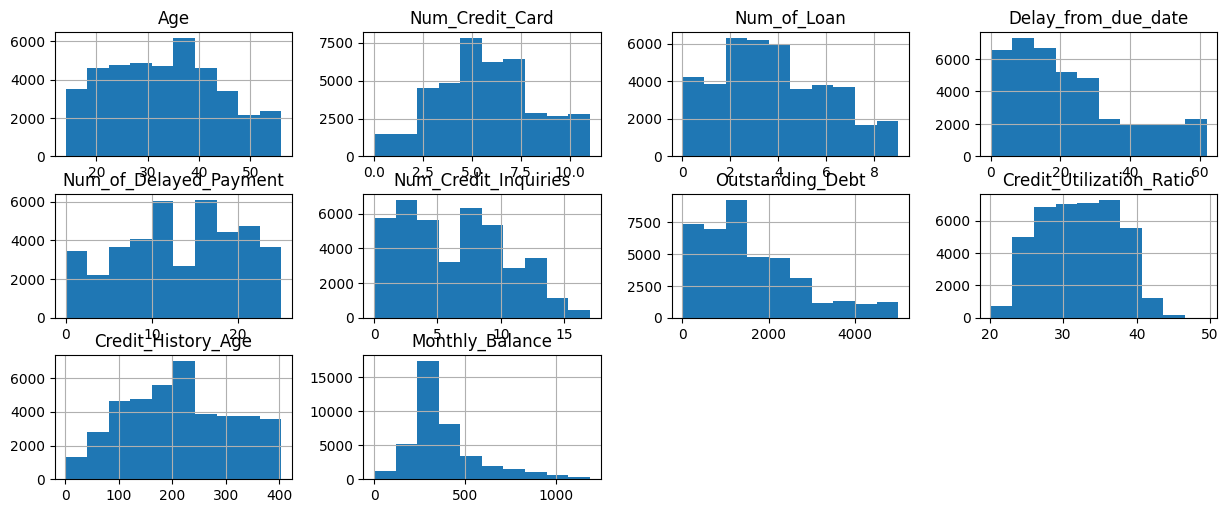

In [208]:
data.hist(layout=(5,4), figsize=(15,10))
plt.show()

In [209]:
# split training/test data

X_train, X_test, y_train, y_test = train_test_split(data.drop('Credit_Score', axis = 1),
                                                    data['Credit_Score'],
                                                    train_size= 0.21, random_state=42, shuffle=True)

print(f'Shapes: X_train {X_train.shape} y_train {y_train.shape} X_test {X_test.shape} y_test {y_test.shape}')

Shapes: X_train (8623, 10) y_train (8623,) X_test (32440, 10) y_test (32440,)


In [210]:
params = {'knn__n_neighbors': np.arange(1,18)}

pipeline = Pipeline([
    # ('transformer', transformer),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_finder = GridSearchCV(pipeline, params, scoring='accuracy', cv=5)
knn_finder.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])},
             scoring='accuracy')

In [211]:
average_accuracy = knn_finder.cv_results_['mean_test_score']
best_k = knn_finder.best_params_['knn__n_neighbors']

print("\n The best estimator across ALL searched params:\n", knn_finder.best_estimator_)
print("\n The best score across ALL searched params:\n", knn_finder.best_score_)
print("\n The best parameters across ALL searched params:\n", knn_finder.best_params_)

print(f'Best "k" value: {best_k}')
print(f'Best average_accuracy value: {average_accuracy}')


 The best estimator across ALL searched params:
 Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])

 The best score across ALL searched params:
 0.8522554221729044

 The best parameters across ALL searched params:
 {'knn__n_neighbors': 9}
Best "k" value: 9
Best average_accuracy value: [0.84228205 0.83242456 0.85005111 0.85121161 0.85167477 0.8507471
 0.85144268 0.85155869 0.85225542 0.85179165 0.8519078  0.85086378
 0.85051649 0.8493566  0.85028421 0.84924073 0.84993685]


In [212]:
train_data_no_score = data.drop('Credit_Score', axis = 1)
train_data_score = data['Credit_Score']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

def get_misclassification_of_k(k):
  model = pipeline.set_params(knn__n_neighbors = k)
  model.fit(train_data_no_score, train_data_score)
  return 1 - accuracy_score(train_data_score, model.predict(train_data_no_score))

ks = np.arange(1,18)
misclassification_errors = [get_misclassification_of_k(k) for k in ks]
print(f'misclassification_errors {misclassification_errors}')

misclassification_errors [0.0, 0.042787911258310385, 0.04583201422204908, 0.06908896086501226, 0.07154859605971309, 0.08591676204855958, 0.08657428828872704, 0.09794705696125461, 0.09721647224995733, 0.10535031536906703, 0.103767381827923, 0.11146287412025424, 0.11029393858217862, 0.11606555780142702, 0.11431215449431364, 0.11954801159194406, 0.11901224947032607]


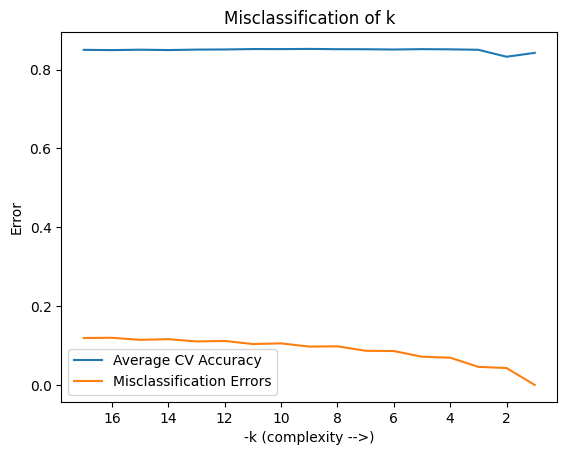

In [213]:
ks = np.arange(1,18)

plt.plot(ks, average_accuracy, label = "Average CV Accuracy")
plt.plot(ks, misclassification_errors, label = "Misclassification Errors")
plt.legend()
plt.gca().invert_xaxis()
plt.xlabel('-k (complexity -->)')
plt.ylabel('Error')
plt.title('Misclassification of k')
plt.show()

In [216]:
knn_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=9))
])
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=9))])

In [217]:
scoring_dict = {}
scoring_dict['precision_score'] = precision_score(y_test, knn_pipeline.predict(X_test), pos_label='Good')
scoring_dict['recall_score'] = recall_score(y_test, knn_pipeline.predict(X_test), pos_label='Good')
scoring_dict['accuracy_score'] = accuracy_score(y_test, knn_pipeline.predict(X_test))

best_score_name = max(scoring_dict, key=scoring_dict.get)
best_score_value = scoring_dict[best_score_name]

print(f'Best score name: {best_score_name} best score value: {best_score_value}')

Best score name: recall_score best score value: 0.8650271893515137


In [223]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [226]:
# Precision, recall and accuracy thresholds when k == 9

model_1 = pipeline.set_params(knn__n_neighbors = 9)
test_predictions_1 = model_1.predict_proba(X_test)

threshold_range = np.arange(0.1, 1.1, 0.1)

def precision_threshold(test_predictions, y_test, threshold):
  predictions = np.where(test_predictions >= threshold, 'Good', 'Poor')
  return precision_score(y_test, predictions, pos_label='Good')

precision_thresholds = [precision_threshold(test_predictions_1[:, 1], y_test, t) for t in threshold_range]

def recall_threshold(test_predictions, y_test, threshold):
  predictions = np.where(test_predictions >= threshold, 'Good', 'Poor')
  return recall_score(y_test, predictions, pos_label='Good')

recall_thresholds = [recall_threshold(test_predictions_1[:, 1], y_test, t) for t in threshold_range]

def accuracy_threshold(test_predictions, y_test, threshold):
  predictions = np.where(test_predictions >= threshold, 'Good', 'Poor')
  return accuracy_score(y_test, predictions)

accuracy_thresholds = [accuracy_threshold(test_predictions_1[:, 1], y_test, t) for t in threshold_range]

precision_recall__accuracy_threshold_df = pd.DataFrame(
    {'threshold': threshold_range,
     'precision': precision_thresholds,
     'recall': recall_thresholds,
     'accuracy': accuracy_thresholds
     })
precision_recall__accuracy_threshold_df

,threshold,precision,recall,accuracy
0,0.1,0.327758,0.788816,0.305302
1,0.2,0.272060,0.589563,0.244975
2,0.3,0.206845,0.395341,0.194575
3,0.4,0.140654,0.236182,0.161837
4,0.5,0.089519,0.134973,0.150062
5,0.6,0.056764,0.079214,0.150339
6,0.7,0.037402,0.049265,0.157337
7,0.8,0.024551,0.030192,0.176048
8,0.9,0.015812,0.015908,0.250154
9,1.0,0.015812,0.015908,0.250154


Text(0.5, 1.0, 'Precision vs Recall when "k" = 9')

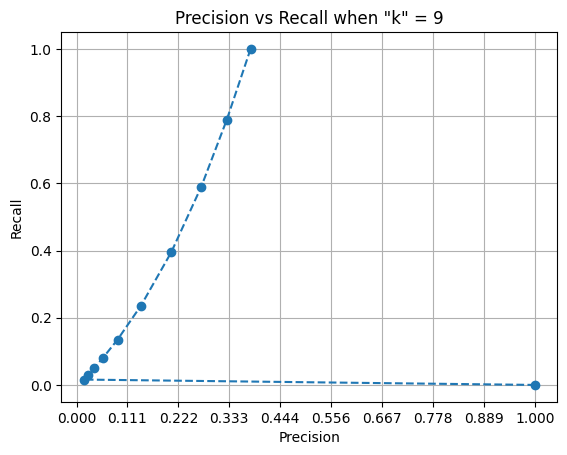

In [228]:
precision, recall, thresholds = precision_recall_curve(y_test, test_predictions_1[:,1], pos_label='Good')

plt.plot(precision, recall, '--o')
plt.xticks(thresholds);
plt.grid()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision vs Recall when "k" = 9')

In [229]:
abs_difference = abs(average_accuracy - misclassification_errors)

average_accuracy_misclassification_errors = pd.DataFrame(
    {
        'k': np.arange(1,18),
        'average_accuracy': average_accuracy,
        'misclassification_errors': misclassification_errors,
        'abs_difference': abs_difference
    }
    )
average_accuracy_misclassification_errors

,k,average_accuracy,misclassification_errors,abs_difference
0,1,0.842282,0.000000,0.842282
1,2,0.832425,0.042788,0.789637
2,3,0.850051,0.045832,0.804219
3,4,0.851212,0.069089,0.782123
4,5,0.851675,0.071549,0.780126
5,6,0.850747,0.085917,0.764830
6,7,0.851443,0.086574,0.764868
7,8,0.851559,0.097947,0.753612
8,9,0.852255,0.097216,0.755039
9,10,0.851792,0.105350,0.746441


accuracy: 0.8499383477188656
precision: 0.9104807019432631
recall ("sensitivity"): 0.8406978478055569
specificity: 0.8650271893515137


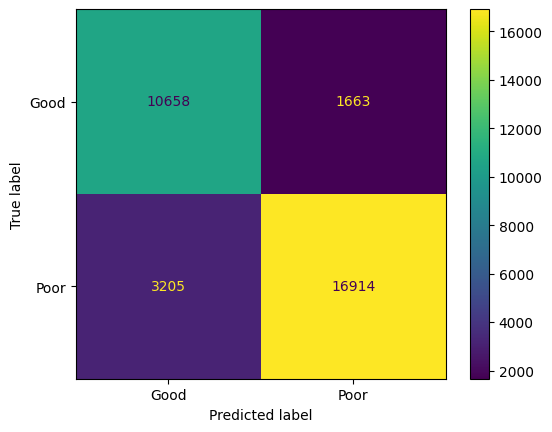

In [233]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

predict_1 = model_1.predict(X_test)

c_matrix_1 = confusion_matrix(y_test, predict_1, labels=['Good', 'Poor'])
tn, fp, fn, tp = c_matrix_1.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall ("sensitivity"): {recall}')
print(f'specificity: {specificity}')

display_c_matrix_1 = ConfusionMatrixDisplay(c_matrix_1, display_labels=['Good', 'Poor'])
display_c_matrix_1.plot()
plt.show()
